In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, sys
import PIL
import time
from IPython import display
from IPython.display import Image as _Imgdis
import imageio
import glob
import tensorflow as tf
import matplotlib
from PIL import Image

In [2]:
matplotlib.use('Agg')
%matplotlib inline

In [3]:
print(tf.__version__)

2.4.1


In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#Preprocess PPE Dataset

#Resize
#f = r'/content/gdrive/MyDrive/5016Project/DCGAN/PPE/'
#for file in os.listdir(f):
#    f_img = f+"/"+file
#    img = Image.open(f_img)
#    img = img.resize((64,64))
#    img.save(f_img)

In [6]:
# Retrive Dataset Information

#folder = r'C:\Users\Paddy\Google Drive (paddykcc@gmail.com)\5016Project\DCGAN\Paddy'

folder = r'/content/gdrive/MyDrive/5016Project/DCGAN/Fruit/'

onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")
print(onlyfiles)

Working with 5079 images
Image examples: 
['Mulberry446.jpg', 'Mulberry474.jpg', 'Mulberry490.jpg', 'Mulberry470.jpg', 'Mulberry476.jpg', 'Mulberry489.jpg', 'Mulberry469.jpg', 'Mulberry458.jpg', 'Mulberry467.jpg', 'Mulberry453.jpg', 'Mulberry478.jpg', 'Mulberry450.jpg', 'Mulberry448.jpg', 'Mulberry475.jpg', 'Mulberry462.jpg', 'Mulberry465.jpg', 'Mulberry484.jpg', 'Mulberry477.jpg', 'Mulberry464.jpg', 'Mulberry473.jpg', 'Mulberry491.jpg', 'Mulberry485.jpg', 'Mulberry449.jpg', 'Mulberry468.jpg', 'Mulberry457.jpg', 'WaterMelon6.jpg', 'WaterMelon3.jpg', 'WaterMelon12.jpg', 'WaterMelon1.jpg', 'WaterMelon20.jpg', 'WaterMelon11.jpg', 'WaterMelon21.jpg', 'WaterMelon15.jpg', 'WaterMelon24.jpg', 'WaterMelon2.jpg', 'WaterMelon8.jpg', 'WaterMelon16.jpg', 'WaterMelon10.jpg', 'WaterMelon14.jpg', 'WaterMelon13.jpg', 'WaterMelon5.jpg', 'WaterMelon25.jpg', 'WaterMelon4.jpg', 'WaterMelon7.jpg', 'WaterMelon26.jpg', 'WaterMelon23.jpg', 'WaterMelon9.jpg', 'WaterMelon22.jpg', 'WaterMelon19.jpg', 'WaterMelon

In [7]:
# Load image from local folder to tensor and normalize to [-1, 1]

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_files = []
y_train = []
i=0
for _file in onlyfiles:
    train_files.append(_file)
    label_in_file = _file.find("_")
    
print("Files in train_files: %d" % len(train_files))

# Original Dimensions
image_width = 64
image_height = 64
channels = 3

train_images = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)

i = 0
for _file in train_files:
    #print(_file)
    img = load_img(folder + "/" + _file)  # this is a PIL image
    img.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img)  
    x = x.reshape((64, 64, 3))
    train_images[i] = x
    i += 1
    if i % 250 == 0:
        print("%d images to array" % i)

#Normalize image to [-1, 1]

train_images /= 127.5
train_images -= 1.

print("All images to array!")

Files in train_files: 5079
250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
All images to array!


In [8]:
print(train_images.shape)

(5079, 64, 64, 3)


In [9]:
print(train_images[0])

[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.99215686 1.         1.        ]
  [0.99215686 1.         1.        ]
  [0.99215686 1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]


In [10]:
BUFFER_SIZE = 5079
BATCH_SIZE = 64

In [11]:
#Create the batch and Shuffle the Training Data

train_dataset = tf.data.Dataset.from_tensor_slices(
    train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
# Create the Generator model

def make_generator_model():
    model = tf.keras.Sequential()

    #Gaussian Weight Initialization by using a zero-centered Gaussian distribution with a standard deviation of 0.02.
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # 4x4x512
    #model.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(128, ), kernel_initializer=initializer)) # Add - due to the change of noise_dim
    #model.add(tf.keras.layers.BatchNormalization()) #momentum=0.8
    #model.add(tf.keras.layers.LeakyReLU(alpha=0.2)) #alpha=0.1
    #model.add(tf.keras.layers.Reshape((4, 4, 512)))
    #print("Model shape should be (None, 4, 4, 512) -", model.output_shape)
    # Note: None is the batch size
    #assert model.output_shape == (None, 4, 4, 512)

    # 4x4x1024
    model.add(tf.keras.layers.Dense(4*4*1024, use_bias=False, input_shape=(128, ), kernel_initializer=initializer)) # Add - due to the change of noise_dim
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8)) #momentum=0.8
    #model.add(tf.keras.layers.LeakyReLU(alpha=0.2)) #alpha=0.1
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Reshape((4, 4, 1024)))
    print("Model shape should be (None, 4, 4, 1024) -", model.output_shape)
    # Note: None is the batch size
    assert model.output_shape == (None, 4, 4, 1024) 

    # 4x4x512 -> 8x8x512
    model.add(tf.keras.layers.Conv2DTranspose(
        512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print("Model shape should be (None, 8, 8, 512) -", model.output_shape)
    assert model.output_shape == (None, 8, 8, 512)
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8)) #momentum=0.8
    #model.add(tf.keras.layers.LeakyReLU(alpha=0.2)) #alpha=0.1
    model.add(tf.keras.layers.ReLU())

    # 8x8x512 -> 16x16x256
    model.add(tf.keras.layers.Conv2DTranspose(
        256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print("Model shape should be (None, 16, 16, 256) -", model.output_shape)
    assert model.output_shape == (None, 16, 16, 256)
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8)) #momentum=0.8
    #model.add(tf.keras.layers.LeakyReLU(alpha=0.2)) #alpha=0.1
    model.add(tf.keras.layers.ReLU())
    
    # 16x16x256 -> 32x32x128
    model.add(tf.keras.layers.Conv2DTranspose(
        128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print("Model shape should be (None, 32, 32, 128) -", model.output_shape)
    assert model.output_shape == (None, 32, 32, 128)
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8)) #momentum=0.8
    #model.add(tf.keras.layers.LeakyReLU(alpha=0.2)) #alpha=0.1
    model.add(tf.keras.layers.ReLU())

    # 32x32x128 -> 64x64x64 (Add this layer)
    model.add(tf.keras.layers.Conv2DTranspose(
        64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print("Model shape should be (None, 64, 64, 64) -", model.output_shape)
    assert model.output_shape == (None, 64, 64, 64)
    model.add(tf.keras.layers.BatchNormalization()) #momentum=0.8
    #model.add(tf.keras.layers.LeakyReLU(alpha=0.2)) #alpha=0.1
    model.add(tf.keras.layers.ReLU())

    # 64x64x64 -> 64x64x3
    #model.add(tf.keras.layers.Conv2DTranspose(
    #    3, (4, 4), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    #print("Model shape should be (None, 64, 64, 3) -", model.output_shape)
    #assert model.output_shape == (None, 64, 64, 3)

    # 32x32x128 -> 64x64x3
    model.add(tf.keras.layers.Conv2DTranspose(
        3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    print("Model shape should be (None, 64, 64, 3) -", model.output_shape)
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [13]:
generator = make_generator_model()

Model shape should be (None, 4, 4, 1024) - (None, 4, 4, 1024)
Model shape should be (None, 8, 8, 512) - (None, 8, 8, 512)
Model shape should be (None, 16, 16, 256) - (None, 16, 16, 256)
Model shape should be (None, 32, 32, 128) - (None, 32, 32, 128)
Model shape should be (None, 64, 64, 64) - (None, 64, 64, 64)
Model shape should be (None, 64, 64, 3) - (None, 64, 64, 3)


In [14]:
# Create the Discriminator model

# The discriminator is responsible for distinguishing fake images from real images. It's similar to a regular CNN-based image classifier.

def make_discriminator_model():
    model = tf.keras.Sequential()

    # 64x64x3 -> 32x32x32
    model.add(tf.keras.layers.Conv2D(
        32, (5, 5), strides=(2, 2), padding='same')) #64
    #Add BN
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2)) #alpha=0.2
    #model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5)) #0.3

    # 32x32x32-> 16x16x64 
    model.add(tf.keras.layers.Conv2D(
        64, (5, 5), strides=(2, 2), padding='same')) #128
    #Add BN
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    #model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))

    # 16x16x64  -> 8x8x128  
    model.add(tf.keras.layers.Conv2D(
        128, (5, 5), strides=(2, 2), padding='same')) #256
    #Add BN
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    #model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))

    # 8x8x128 -> 8x8x256
    model.add(tf.keras.layers.Conv2D(
        256, (5, 5), strides=(2, 2), padding='same')) #256
    #Add BN
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    #model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))

    # 8x8x256 -> 4x4x512
    model.add(tf.keras.layers.Conv2D(
        512, (5, 5), strides=(2, 2), padding='same')) #256
    #Add BN
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    #model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1)) 

    return model

In [15]:
discriminator = make_discriminator_model()

In [16]:
# Define the loss functions and the optimizer for Generator
def generator_loss(generated_output):
  return tf.compat.v1.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [17]:
generator_optimizer = tf.compat.v1.train.AdamOptimizer(1e-4) #1e-4

In [18]:
def smooth_positive_labels(y):
	return y - 0.3 + (tf.random.normal(y.shape) * 0.5)

In [19]:
def smooth_negative_labels(y):
	return y + tf.random.normal(y.shape) * 0.3

In [20]:
# Define the loss functions and the optimizer for Discriminator

#The discriminator loss function takes two inputs: real images, and generated images. Here is how to calculate the discriminator loss:
#1. Calculate real_loss which is a sigmoid cross entropy loss of the real images and an array of ones (since these are the real images).
#2. Calculate generated_loss which is a sigmoid cross entropy loss of the generated images and an array of zeros (since these are the fake images).
#3. Calculate the total_loss as the sum of real_loss and generated_loss.

def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    #real_loss = tf.compat.v1.losses.sigmoid_cross_entropy(
        #multi_class_labels=tf.ones_like(real_output), logits=real_output)
    
    # Add +ve Label Smoothing
    mcl_positive=tf.ones_like(real_output)
    mcl_positive=smooth_positive_labels(mcl_positive)
    real_loss = tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=mcl_positive, logits=real_output)
    
    
    # [0,0,...,0] with generated images since they are fake
    #generated_loss = tf.compat.v1.losses.sigmoid_cross_entropy(
    #    multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    # Add -ve Label Smoothing
    mcl_negative=tf.zeros_like(generated_output)
    mcl_negative=smooth_negative_labels(mcl_negative)
    generated_loss = tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=mcl_negative, logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [21]:
discriminator_optimizer = tf.compat.v1.train.AdamOptimizer(1e-4) #1e-4

In [22]:
# Define Checkpoint

checkpoint_dir = '/content/gdrive/MyDrive/5016Project/DCGAN/checkpoints_fruit'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
# Set up GANs for Training

EPOCHS = 200
noise_dim = 128 #Add (100)
num_examples_to_generate = 32 #16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])

In [24]:
#  Plot Loss

def plot_loss(history):
        hist = pd.DataFrame(history)
        plt.figure(figsize=(20,5))
        plt.legend()
        plt.ylabel("Loss")
        plt.xlabel("epochs")
        plt.title('Discriminator and Generator Loss vs Epoch')

        ax = plt.gca()
        hist.plot(kind='line',x='Epoch',y='D',ax=ax)
        hist.plot(kind='line',x='Epoch',y='G', color='red', ax=ax)
        
        plt.show()

        print(hist)

In [25]:
# Define Training Method

def train_step(images):
   # Add Gussian noise to the generated image
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        #Add Gussian noise to the real image
        images = images + tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=0.1, dtype=tf.float32)

        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.variables))
    
    return gen_loss, disc_loss  #Add

In [26]:
def train(dataset, epochs):

    loss_hist = [] #Add

    for epoch in range(epochs):
        start = time.time()

        for images in dataset:
            gen_loss_hist, disc_loss_hist = train_step(images) #Add
            
        loss_hist.append({"Epoch":epoch,"D":gen_loss_hist.numpy(),"G":disc_loss_hist.numpy()})
        
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 random_vector_for_generation)

        # saving (checkpoint) the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                         time.time()-start))
    # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             random_vector_for_generation)
    
    display.clear_output(wait=True)
    plot_loss(loss_hist)   #Add


In [27]:
# Generate and save images

def generate_and_save_images(model, epoch, test_input):
    #
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(test_input.shape[0]):
        plt.subplot(8, 8, i+1)
        predi = convert_array_to_image(predictions[i])

        plt.imshow(predi)
        plt.axis('off')

    plt.savefig('/content/gdrive/MyDrive/5016Project/DCGAN/image_fruit/' + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [28]:
def convert_array_to_image(array):
    """Converts a numpy array to a PIL Image and undoes any rescaling."""
    img = PIL.Image.fromarray(np.uint8((array + 1.0) / 2.0 * 255), mode='RGB')
    return img

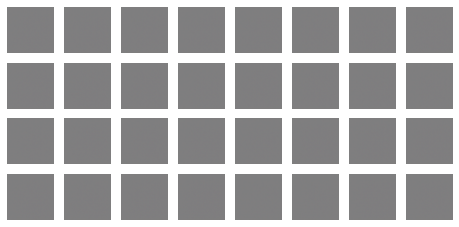

In [29]:
pred = generator(random_vector_for_generation, training=False)
generate_and_save_images(generator, 1, random_vector_for_generation)

In [30]:
#Restore the latest checkpoint

#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


No handles with labels found to put in legend.


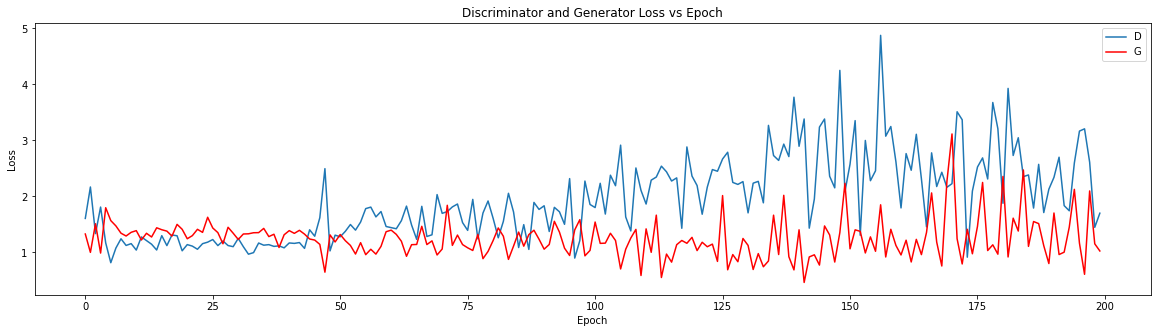

     Epoch         D         G
0        0  1.606927  1.328460
1        1  2.168265  1.000863
2        2  1.335842  1.512130
3        3  1.809812  0.988307
4        4  1.170131  1.798047
..     ...       ...       ...
195    195  3.166747  1.164929
196    196  3.206861  0.608667
197    197  2.610394  2.097479
198    198  1.447735  1.153534
199    199  1.700374  1.025568

[200 rows x 3 columns]


In [31]:
# Train the GAN

print("Num epochs", EPOCHS)
train(train_dataset, EPOCHS)

In [32]:
# Generated images

def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [33]:
# Generate a GIF of all the saved images

with imageio.get_writer('/content/gdrive/MyDrive/5016Project/DCGAN/gif/dcgan_fruit.gif', mode='I') as writer:
    filenames = glob.glob(r'/content/gdrive/MyDrive/5016Project/DCGAN/image_fruit/*.png') 
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)


In [34]:
# Display the gif inside the notebook

os.system('cp /content/gdrive/MyDrive/5016Project/DCGAN/gif/dcgan_fruit.gif /content/gdrive/MyDrive/5016Project/DCGAN/gif/dcgan_fruit.gif.png')

0

In [ ]:
# Display the animated gif with all the images generated during the training of GANs."""

display.Image(filename="/content/gdrive/MyDrive/5016Project/DCGAN/gif/dcgan_fruit.gif.png")